In [ ]:
!pip install transformers datasets scikit-learn joblib matplotlib seaborn --quiet

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from datasets import Dataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from torch.nn.functional import softmax
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipython-input-1651771540.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fake_review_label', data=df_balanced, palette='Set2')


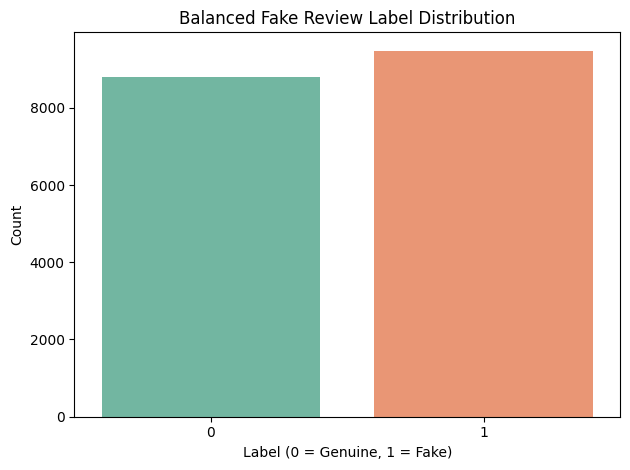

In [ ]:
df = pd.read_parquet("/content/engineered_features_with_anomalies.parquet")
df = df[['clean_text', 'fake_review_label']].dropna()

# Oversample class 1 (fake reviews)
df_fake = df[df['fake_review_label'] == 1]
df_balanced = pd.concat([
    df,
    df_fake.sample(n=len(df[df['fake_review_label'] == 0]), replace=True)
])

sns.countplot(x='fake_review_label', data=df_balanced, palette='Set2')
plt.title("Balanced Fake Review Label Distribution")
plt.xlabel("Label (0 = Genuine, 1 = Fake)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
fake_reviews = df[df['fake_review_label'] == 0]
fake_reviews.head(70)

,clean_text,fake_review_label
4,husband bought gel us gel caused irritation fe...,0
6,bought earlier today excited check based produ...,0
7,bought product husband try impressed tingling ...,0
8,husband bought extra fun werevboth extremely d...,0
9,got surprise husband nothing special lube save...,0
...,...,...
72,although product worked amazingly well fragran...,0
73,love product used least years prefer old formu...,0
74,want try answer questions sounds like product ...,0
75,product really helped keep skin moisturized wi...,0


In [ ]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(df_balanced['fake_review_label']),
                                     y=df_balanced['fake_review_label'])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

dataset = Dataset.from_pandas(df_balanced[['clean_text', 'fake_review_label']])
dataset = dataset.train_test_split(test_size=0.2, seed=42)

def tokenize_function(example):
    return tokenizer(example['clean_text'], truncation=True, padding='max_length', max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'fake_review_label'])

train_dataloader = DataLoader(tokenized_dataset['train'], batch_size=16, shuffle=True)
eval_dataloader = DataLoader(tokenized_dataset['test'], batch_size=16)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/14624 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 10
lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_epochs * len(train_dataloader))

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
best_val_loss = float('inf')
patience = 2
counter = 0

for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        labels=batch['fake_review_label'])
        loss = loss_fn(outputs.logits, batch['fake_review_label'])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step(); lr_scheduler.step(); optimizer.zero_grad()

    # Validation
    model.eval(); val_loss = 0
    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch['input_ids'],
                            attention_mask=batch['attention_mask'],
                            labels=batch['fake_review_label'])
            loss = loss_fn(outputs.logits, batch['fake_review_label'])
            val_loss += loss.item()

    avg_val_loss = val_loss / len(eval_dataloader)
    print(f"Epoch {epoch} - Validation Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss:
        best_val_loss, counter = avg_val_loss, 0
        torch.save(model.state_dict(), "best_model_oversampled.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered."); break

Epoch 0: 100%|██████████| 914/914 [01:15<00:00, 12.15it/s]


Epoch 0 - Validation Loss: 0.1511


Epoch 1: 100%|██████████| 914/914 [01:14<00:00, 12.35it/s]


Epoch 1 - Validation Loss: 0.1807


Epoch 2: 100%|██████████| 914/914 [01:13<00:00, 12.36it/s]


Epoch 2 - Validation Loss: 0.1623
Early stopping triggered.


              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1786
           1       0.90      1.00      0.95      1870

    accuracy                           0.95      3656
   macro avg       0.95      0.94      0.94      3656
weighted avg       0.95      0.95      0.94      3656



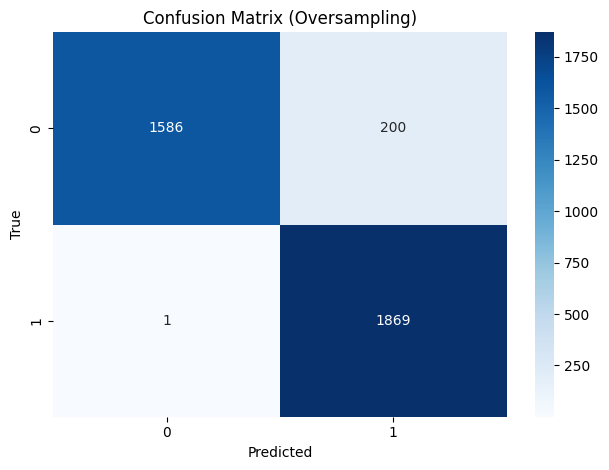

Accuracy for Class 0 (Genuine): 88.80%
Accuracy for Class 1 (Fake): 99.95%


In [ ]:
model.load_state_dict(torch.load("best_model_oversampled.pt"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'])
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['fake_review_label'].cpu().numpy())

report = classification_report(all_labels, all_preds, zero_division=0, output_dict=True)
print(classification_report(all_labels, all_preds, zero_division=0))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Oversampling)")
plt.tight_layout()
plt.show()

for i in range(2):
    correct = np.sum((np.array(all_labels) == i) & (np.array(all_preds) == i))
    total = np.sum(np.array(all_labels) == i)
    acc = correct / total if total > 0 else 0
    print(f"Accuracy for Class {i} ({['Genuine','Fake'][i]}): {acc:.2%}")

In [ ]:
joblib.dump({
    "classification_report": report,
    "confusion_matrix": cm.tolist(),
    "class_weights": class_weights.tolist()
}, "bert_oversampling_metrics.pkl")

torch.save(model.state_dict(), "final_oversampling_model.pt")
model.save_pretrained("bert_oversampling_model")
tokenizer.save_pretrained("bert_oversampling_model")

('bert_oversampling_model/tokenizer_config.json',
 'bert_oversampling_model/special_tokens_map.json',
 'bert_oversampling_model/vocab.txt',
 'bert_oversampling_model/added_tokens.json')